# Intel Image Classification Using Various PyTorch Convolutional Neural Network Designs

## Preprocessing Data and Displaying Images

Here we download the intel image classification dataset and preprocess the data to a train and test dataset. We will use a convolutional neural network (CNN) as opposed to a multilayer perceptron (MLP) neural network or a Recurrent Neural Network (RNN) as we want to take full advantage of the spatial recognition power CNNs have for image data. For this project, we will tune various aspects of the CNN to observe their effects on the accuracy of classifying the data.

In [1]:
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = path + "\\seg_train"
test_dir = path + "\\seg_test"

Next we will plot the first 5 images in each directory (class), and define and run our function which loads the image data. 

Importantly we will also standardize the images to a size of 128x128. 

Shape of buildings images: (150, 150, 3)
Shape of forest images: (150, 150, 3)
Shape of glacier images: (150, 150, 3)
Shape of mountain images: (150, 150, 3)
Shape of sea images: (150, 150, 3)
Shape of street images: (150, 150, 3)


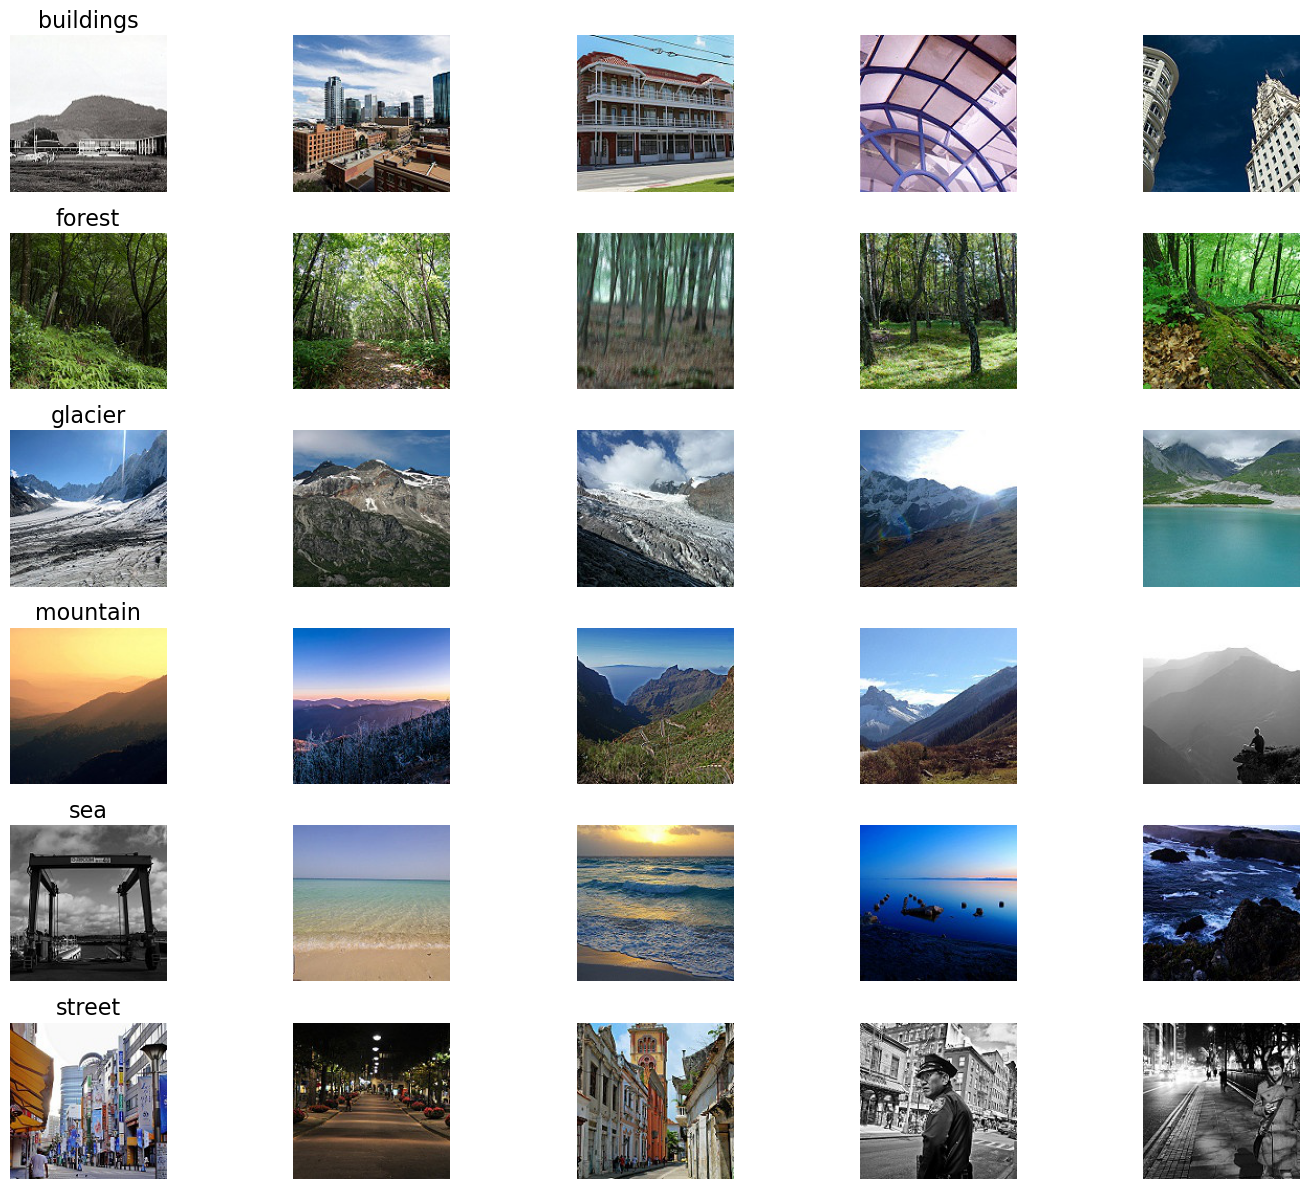

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Loading C:\Users\David\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train... 


100%|██████████| 2382/2382 [00:01<00:00, 1520.32it/s]


Loading C:\Users\David\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_test... 


100%|██████████| 501/501 [00:00<00:00, 2031.84it/s]


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2

image_classes = os.listdir(train_dir)
images_to_display = 5
fig, ax = plt.subplots(len(image_classes), images_to_display, figsize=(15, len(image_classes) * 2))

for i, image_class in enumerate(image_classes):
    class_dir = os.path.join(train_dir, image_class)
    images = os.listdir(class_dir)[:images_to_display]

    for j, image in enumerate(images):
        img_path = os.path.join(class_dir, image)
        img = np.asarray(Image.open(img_path))
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        if j == 0:
            ax[i,j].set_title(image_class, size=16)
            print(f"Shape of {image_class} images: {img.shape}")

plt.tight_layout()
plt.show()
        
class_labels = {class_name:i for i, class_name in enumerate(image_classes)}
print(class_labels)

IMAGE_SIZE = (128,128)

def load_data():
    datasets = [train_dir, test_dir]
    output = []

    for dataset in datasets:

        images = []
        labels = []

        print(f"Loading {dataset}... ")

        for folder in os.listdir(dataset):

            label = class_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                images.append(img)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

((train_images, train_labels), (test_images, test_labels)) = load_data()

There are some images where the difference may be difficult to tell, even for a human eye. For example, the fifth image in the glacier row could readily also be interpreted as a sea or a mountain by a human observer, yet it is still labeled as a glacier. Furthermore, many of the glaciers could also be interpreted as mountains, if not for the snow and ice in the photos. The difference in classifying an image as a street or an image as a building also seems to be up in the air. We should keep this in mind to explain any potential inaccuracies in classificiation when we train our model. 

Now we can set up the GPU to be used for training and predicting inputs from our model. I have a GPU, which will help with parallelizing calculations from the neural network I will build. The analysis can also be done on only a CPU, but the training time may be much longer.

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

print(f'PyTorch Version = {torch.__version__}')
print(f'CUDA Available = {torch.cuda.is_available()}')
print('CUDA version and Build Information:')
!nvcc --version
print()

# CUDNN Installation Information
print(f'CUDNN Version: {torch.backends.cudnn.version()}')
print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
print(f'Active CUDA Device: {torch.cuda.current_device()}')
print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
print(f'Current CUDA device: {torch.cuda.current_device()}')

gpu = torch.device('cuda:0')

PyTorch Version = 2.7.0+cu128
CUDA Available = True
CUDA version and Build Information:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:42:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0

CUDNN Version: 90701
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: NVIDIA GeForce GTX 1660 SUPER
Current CUDA device: 0


The CNN classifier will be created using the `nn.Module` class as a parent class and design the neural network such that a dynamic number of convolutional layers may be passed as a parameter.

The number of base channels is set to be a defualt of 32, which may be changed to have a more expressive model (increasing `base_channels`) or a smaller model (decreasing `base_channels`).

In [4]:
class ConvNN(nn.Module):

    def __init__(self, n_channels, n_layers=3, base_channels=32, epochs=100, eta=0.001, minibatch_size=50):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_layers = n_layers
        self.base_channels = base_channels
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size

        self.convolutional_layers = nn.ModuleList()
        self.flattened_dimensions = None
        self.fc_layer = None

    def _initialize_layers(self, base_channels, in_channels, n_layers, n_classes):
        
        out_channels = 0
        output_compression = 256 # may change this to be a parameter if desired

        # convolutional layers
        for i in range(n_layers):
            out_channels = base_channels * (2 ** i)
            self.convolutional_layers.append(nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=3, 
                padding=1
            ).to(gpu))
            self.convolutional_layers.append(nn.ReLU().to(gpu))
            self.convolutional_layers.append(nn.MaxPool2d(2).to(gpu))
            in_channels = out_channels

        # fully connected component
        self.flattened_dimensions = out_channels * (128 // (2 ** n_layers)) ** 2
        self.fc_layer = nn.Sequential(
            nn.Linear(self.flattened_dimensions, output_compression),
            nn.ReLU(),
            nn.Linear(output_compression, n_classes)
        ).to(gpu)

    def _forward(self, X : torch.Tensor, apply_softmax=False):
        X = X.to(gpu)
        for layer in self.convolutional_layers:
            X = layer(X)
        X = torch.flatten(X, start_dim=1)
        X = self.fc_layer(X)

        if apply_softmax:
            X = nn.functional.softmax(X, dim=1)

        return X
    
    def _reset(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                module.reset_parameters()

    def predict(self, X:torch.Tensor, batch_size=50):
        assert len(self.convolutional_layers) > 0 and self.fc_layer is not None

        self.eval()
        preds = []

        with torch.no_grad():
            for start in range(0, X.shape[0], batch_size):
                end = min(start + batch_size, X.shape[0])
                batch = X[start:end].to(gpu)
                outputs = self._forward(batch, apply_softmax=True)
                batch_preds = torch.argmax(outputs, dim=1)
                preds.append(batch_preds.cpu())

        return torch.cat(preds)

    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor):

        self.train()

        X_train = X_train.to(gpu, non_blocking=True)
        y_train = y_train.to(gpu, non_blocking=True).long()

        n_classes = torch.unique(y_train).shape[0]
        self._initialize_layers(self.base_channels, self.n_channels, self.n_layers, n_classes)

        self._reset()

        optimizer = optim.SGD(self.parameters(), lr=self.eta) # use SGD to be consistent with past nn
        loss_function = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):

            indices = torch.randperm(X_train.shape[0])

            for start_idx in range(0, len(indices) - self.minibatch_size + 1, self.minibatch_size):
                
                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                optimizer.zero_grad()
                outputs = self._forward(X_train[batch_idx])
                loss = loss_function(outputs, y_train[batch_idx])
                loss.backward()
                optimizer.step()

        print("Model fitting complete.")

Now that we have designed the neural network, we can fit our image data to the network and determine the reclassification accuracy (to assess any overfitting) and the classification accuracy.

First, we need to convert our image data into tensors, which then need to be permuted such that they fit the format PyTorch needs for image tensors, (N, C, H, W), where N = batch size, C = number of channels, H = image height, and W = image width.

In [5]:
train_images_tensor = torch.tensor(train_images)
train_images_tensor_permuted = train_images_tensor.permute(0,3,1,2)
train_labels_tensor = torch.tensor(train_labels)
test_images_tensor = torch.tensor(test_images)
test_images_tensor_permuted = test_images_tensor.permute(0,3,1,2)

convnn = ConvNN(n_channels=3, n_layers=3, base_channels=32, epochs=10, eta=0.001, minibatch_size=50)
convnn.fit(train_images_tensor_permuted, train_labels_tensor)

Model fitting complete.


Using our neural network to predict the class of images in our training dataset for reclassification accuracy:

In [6]:
y_pred_reclassification = convnn.predict(train_images_tensor_permuted, 50)

In [7]:
from sklearn.metrics import accuracy_score

print(f"Reclassification accuracy: {accuracy_score(train_labels, y_pred_reclassification):.3f}")

Reclassification accuracy: 0.898


The reclassification accuracy tells us the degree to which a model might be overfitted. A reclassification accuracy closer to 1 may be a strong indicator of overfitting. In this case, the reclassification accuracy seems to be reasonable.

Next we will classify the test images dataset.

In [8]:
y_pred = convnn.predict(test_images_tensor_permuted, 50)

print(f"Classification accuracy: {accuracy_score(test_labels, y_pred):.3f}")

Classification accuracy: 0.800


Without any hyperparameter tuning the model is able to correctly predict the class of an image around 3/4 of the time, which is decent. Let's see where the model gets confused by using a confusion matrix.

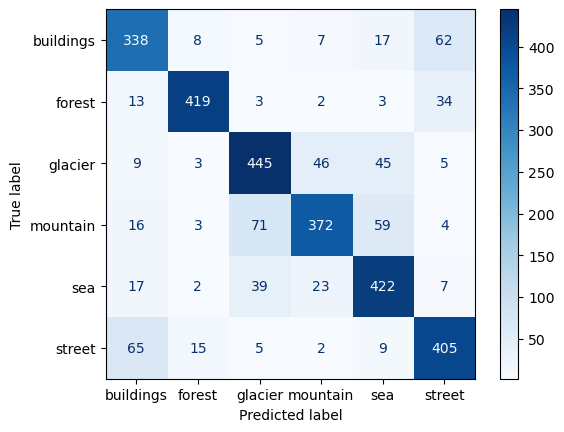

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       437
           1       0.93      0.88      0.91       474
           2       0.78      0.80      0.79       553
           3       0.82      0.71      0.76       525
           4       0.76      0.83      0.79       510
           5       0.78      0.81      0.80       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_confusion_matrix(test_labels, y_pred, generate_classification_report = True):
    
    cm = confusion_matrix(test_labels, y_pred)

    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_labels
    )

    cm_display.plot(cmap="Blues")

    plt.show()

    if generate_classification_report:
        print(classification_report(test_labels, y_pred))

plot_confusion_matrix(test_labels, y_pred, True)

It seems that the model is having the most difficulty differentiating between a sea and a mountain. The model also seems to have some difficulty telling the difference between glaciers and mountains, as well as buildings and streets, which is in line with the challenges in differentiating I expected before. The model appears to have the least difficulty in classifying images that are forests.

Let's see if we can experiment with the design of our CNN to improve performance at all.

## Adding L2 Regularization and Dropout Layers

We should now experiment with tuning some features of our CNN. First, we will assess the impact of using L2 regularization for our stochastic gradient descent (SGD) process. Second, we will assess the impact of adding dropout layers after convolutional layers to our neural network. Finally, we will combine both features and compare how the three perform against the base `ConvNN` model with no regularization or dropout.

### Adding only regularization features to CNN

To implement L2 regularization, we will have create a new parameter in our constructor which determines the value passed to the `weight_decay` parameter in the SGD function. This should not significantly alter the computational complexity of our model.

In [10]:
class ConvNN_L2Reg(ConvNN):

    def __init__(self, n_channels, n_layers=3, base_channels=32, epochs=100, eta=0.001, minibatch_size=50, weight_decay=1e-4):
        super().__init__(n_channels, n_layers, base_channels, epochs, eta, minibatch_size)
        self.weight_decay = weight_decay

    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor):
        
        self.train()

        X_train = X_train.to(gpu, non_blocking=True)
        y_train = y_train.to(gpu, non_blocking=True).long()

        n_classes = torch.unique(y_train).shape[0]
        self._initialize_layers(self.base_channels, self.n_channels, self.n_layers, n_classes)
        self._reset()

        optimizer = optim.SGD(self.parameters(), lr=self.eta, weight_decay=self.weight_decay)
        loss_function = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):

            indices = torch.randperm(X_train.shape[0])

            for start_idx in range(0, len(indices) - self.minibatch_size + 1, self.minibatch_size):

                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                optimizer.zero_grad()
                outputs = self._forward(X_train[batch_idx])
                loss = loss_function(outputs, y_train[batch_idx])
                loss.backward()
                optimizer.step()

        print("Model fitting with L2 regularization complete.")


Now we will fit the model aganist the training images.

In [11]:
convnn_l2 = ConvNN_L2Reg(n_channels=3, n_layers=3, base_channels=32, epochs=10, eta=0.001, minibatch_size=50, weight_decay=0.0001)
convnn_l2.fit(train_images_tensor_permuted, train_labels_tensor)

Model fitting with L2 regularization complete.


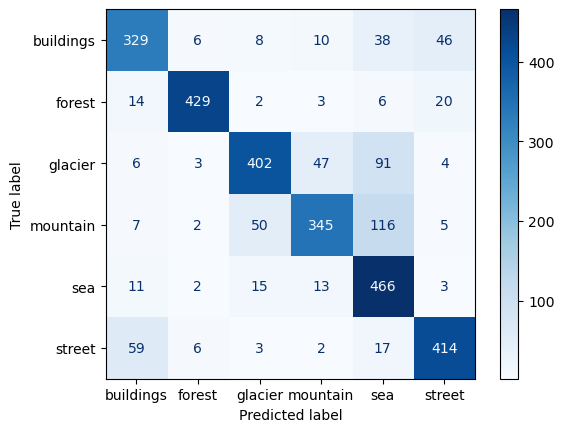

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       437
           1       0.96      0.91      0.93       474
           2       0.84      0.73      0.78       553
           3       0.82      0.66      0.73       525
           4       0.63      0.91      0.75       510
           5       0.84      0.83      0.83       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



In [12]:
y_pred_l2 = convnn_l2.predict(test_images_tensor_permuted, 50)

plot_confusion_matrix(test_labels, y_pred_l2, True)

We can see that with L2 regularization the model already performs better than the base CNN without L2 regularization, in terms of being able to differentiate between images of the sea and images of mountains, but also in terms of being able to differentiate glaciers and mountains.

### Adding only dropout layers to CNN:

To implement dropout layers, we will use the PyTorch module `nn.Dropout()` and append it after every convolutional layer and activation function we add to the model. For this model, we will implement a standard dropout rate of p=0.2, and simply build upon the base `ConvNN` class we already created.

In [13]:
class ConvNN_DL(ConvNN):

    def _initialize_layers(self, base_channels, in_channels, n_layers, n_classes, dropout_rate=0.2):
        
        out_channels = 0
        output_compression = 256

        for i in range(n_layers):
            out_channels = base_channels * (2 ** i)
            self.convolutional_layers.append(nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1
            ).to(gpu))
            self.convolutional_layers.append(nn.ReLU().to(gpu))
            self.convolutional_layers.append(nn.Dropout(dropout_rate).to(gpu))
            self.convolutional_layers.append(nn.MaxPool2d(2).to(gpu))
            in_channels = out_channels

        self.flattened_dimensions = out_channels * (128 // (2 ** n_layers)) ** 2
        self.fc_layer = nn.Sequential(
            nn.Linear(self.flattened_dimensions, output_compression),
            nn.ReLU(),
            nn.Linear(output_compression, n_classes)
        ).to(gpu)

Training the model:

In [14]:
convnn_dl = ConvNN_DL(n_channels=3, n_layers=3, base_channels=32, epochs=10, eta=0.001, minibatch_size=50)
convnn_dl.fit(train_images_tensor_permuted, train_labels_tensor)

Model fitting complete.


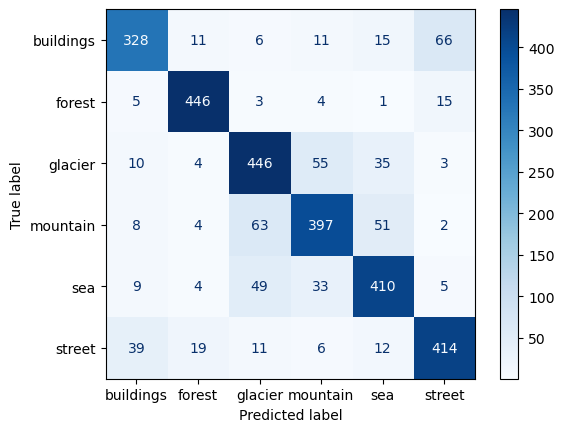

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       437
           1       0.91      0.94      0.93       474
           2       0.77      0.81      0.79       553
           3       0.78      0.76      0.77       525
           4       0.78      0.80      0.79       510
           5       0.82      0.83      0.82       501

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [15]:
y_pred_dl = convnn_dl.predict(test_images_tensor_permuted, 50)

plot_confusion_matrix(test_labels, y_pred_dl, True)

Adding dropout layers to the model also improved the ability for the model to differentiate between images of mountains and images of seas.

### Combining L2 Regularization and Dropout Layers

Now we will combine both L2 regularization and our dropout layers to observe the performance of the model. For this model, we will can simply add dropout layers to the `ConvNN_L2Reg` model we already created.

In [16]:
class ConvNN_DL_L2Reg(ConvNN_L2Reg):

    def _initialize_layers(self, base_channels, in_channels, n_layers, n_classes, dropout_rate=0.2):
        
        out_channels = 0
        output_compression = 256

        for i in range(n_layers):
            out_channels = base_channels * (2 ** i)
            self.convolutional_layers.append(nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1
            ).to(gpu))
            self.convolutional_layers.append(nn.ReLU().to(gpu))
            self.convolutional_layers.append(nn.Dropout(dropout_rate).to(gpu))
            self.convolutional_layers.append(nn.MaxPool2d(2).to(gpu))
            in_channels = out_channels

        self.flattened_dimensions = out_channels * (128 // (2 ** n_layers)) ** 2
        self.fc_layer = nn.Sequential(
            nn.Linear(self.flattened_dimensions, output_compression),
            nn.ReLU(),
            nn.Linear(output_compression, n_classes)
        ).to(gpu)

Training the model:

In [17]:
convnn_dl_l2 = ConvNN_DL_L2Reg(n_channels=3, n_layers=3, base_channels=32, epochs=10, eta=0.001, minibatch_size=50, weight_decay=0.0001)
convnn_dl_l2.fit(train_images_tensor_permuted, train_labels_tensor)

Model fitting with L2 regularization complete.


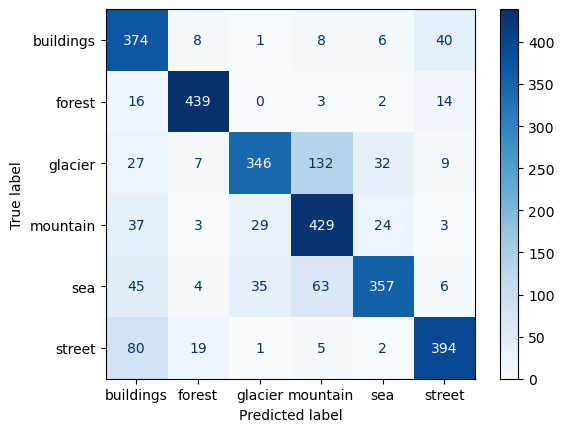

              precision    recall  f1-score   support

           0       0.65      0.86      0.74       437
           1       0.91      0.93      0.92       474
           2       0.84      0.63      0.72       553
           3       0.67      0.82      0.74       525
           4       0.84      0.70      0.77       510
           5       0.85      0.79      0.81       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.80      0.78      0.78      3000



In [18]:
y_pred_dl_l2 = convnn_dl_l2.predict(test_images_tensor_permuted, 50)

plot_confusion_matrix(test_labels, y_pred_dl_l2, True)

Now we should observe if there is any disparity in overfitting between the different variants of the models. A simple way to determine this would be to evaluate the reclassification efficiency by predicting the classes in the testing dataset.

In [19]:
nns = {
    "Base CNN (Reclassification)":convnn,
    "CNN with L2 regularization (Reclassification)":convnn_l2,
    "CNN with dropout layer (Reclassification)":convnn_dl,
    "CNN with L2 regularization and dropout layer (Reclassification)":convnn_dl_l2
}

def compare_accuracies(nns:dict, dataset, dataset_labels, batch_size):

    accs = []

    for name in nns:
        neural_network = nns.get(name)

        y_pred_reclassification = neural_network.predict(dataset, batch_size)
        acc = accuracy_score(dataset_labels, y_pred_reclassification)
        accs.append(acc)

        print(f"Classification Accuracy of {name}: {acc:.3f}")
        print("-" * 100)

    return accs

reclassification_accs = compare_accuracies(
    nns, 
    train_images_tensor_permuted, 
    train_labels, 
    50
)

Classification Accuracy of Base CNN (Reclassification): 0.898
----------------------------------------------------------------------------------------------------
Classification Accuracy of CNN with L2 regularization (Reclassification): 0.909
----------------------------------------------------------------------------------------------------
Classification Accuracy of CNN with dropout layer (Reclassification): 0.923
----------------------------------------------------------------------------------------------------
Classification Accuracy of CNN with L2 regularization and dropout layer (Reclassification): 0.885
----------------------------------------------------------------------------------------------------


It seems that the influence of adding only L2 regularization alone is not enough to significantly alter levels of overfitting, although the addition of both L2 regularization and dropout layers together help to reduce overfitting somewhat. However, as we have seen with the test image dataset, adding both elements may cause lower classification accuracy overall.

Now we will add batch normalization and early stopping features to our model and evaluate their effect on model performance. However, to implement early stopping, we would need to have a validation dataset and calculate the validation loss on every epoch of training. Therefore, we will create a new function which takes in the data to create a validation dataset from the training dataset with a specified `validation_split`.

In [20]:
from sklearn.model_selection import train_test_split

def load_data_with_validation(validation_split=0.2):

    datasets = [train_dir, test_dir]
    output = []

    for dataset in datasets:

        images = []
        labels = []

        print(f"Loading {dataset}...")

        for folder in os.listdir(dataset):
            
            label = class_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                images.append(img)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    train_images, train_labels = output[0]
    test_images, test_labels = output[1]

    X_train, X_val, y_train, y_val = train_test_split(
        train_images,
        train_labels,
        test_size=validation_split,
        stratify=train_labels,
        random_state=42
    )

    return (X_train, y_train), (X_val, y_val), (test_images, test_labels)
    
((X_train, y_train), (X_val, y_val), (X_test, y_test)) = load_data_with_validation(0.2)

Loading C:\Users\David\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train...


100%|██████████| 2382/2382 [00:01<00:00, 1545.61it/s]


Loading C:\Users\David\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_test...


100%|██████████| 501/501 [00:00<00:00, 2020.30it/s]


To implement batch normalization, we will build on the model we created with the dropout layers and L2 regularization by adding a BatchNorm2d dropout layer between the ReLU activation function and the dropout layer.

As for implementing early stopping, we will compare the validation loss in each epoch and halt training when we find that no significant improvements can be made from additional training.

In [21]:
class ConvNN_AllFeatures(ConvNN_DL_L2Reg):
    
    def __init__(self, n_channels, n_layers=3, base_channels=32, epochs=100, eta=0.001, minibatch_size=50, weight_decay=0.0001, patience=5, es_delta=0):
        super().__init__(n_channels, n_layers, base_channels, epochs, eta, minibatch_size, weight_decay)
        self.patience = patience
        self.es_delta = es_delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def _check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.es_delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                print("Stopped training early as no improvement observed.")

    def _initialize_layers(self, base_channels, in_channels, n_layers, n_classes, dropout_rate=0.2):
        
        out_channels = 0
        output_compression = 256

        for i in range(n_layers):
            out_channels = base_channels * (2 ** i)
            self.convolutional_layers.append(nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1
            ).to(gpu))
            self.convolutional_layers.append(nn.ReLU().to(gpu))
            self.convolutional_layers.append(nn.BatchNorm2d(out_channels).to(gpu))
            self.convolutional_layers.append(nn.Dropout(dropout_rate).to(gpu))
            self.convolutional_layers.append(nn.MaxPool2d(2).to(gpu))
            in_channels = out_channels

        self.flattened_dimensions = out_channels * (128 // (2 ** n_layers)) ** 2
        self.fc_layer = nn.Sequential(
            nn.Linear(self.flattened_dimensions, output_compression),
            nn.ReLU(),
            nn.Linear(output_compression, n_classes)
        ).to(gpu)

    def _reset(self):
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                module.reset_parameters()
         
    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor, X_val:torch.Tensor, y_val:torch.Tensor):

        self.train()

        X_train = X_train.to(gpu, non_blocking=True)
        y_train = y_train.to(gpu, non_blocking=True).long()
        X_val = X_val.to(gpu, non_blocking=True)
        y_val = y_val.to(gpu, non_blocking=True).long()

        n_classes = torch.unique(y_train).shape[0]
        self._initialize_layers(self.base_channels, self.n_channels, self.n_layers, n_classes)
        self._reset()

        optimizer = optim.SGD(self.parameters(), lr=self.eta, weight_decay=self.weight_decay)
        loss_function = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):

            indices = torch.randperm(X_train.shape[0])

            for start_idx in range(0, len(indices) - self.minibatch_size + 1, self.minibatch_size):

                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                optimizer.zero_grad()
                outputs = self._forward(X_train[batch_idx])
                loss = loss_function(outputs, y_train[batch_idx])
                loss.backward()
                optimizer.step()
                
            self.eval()

            with torch.no_grad():
                val_outputs = self._forward(X_val)
                val_loss = loss_function(val_outputs, y_val).item()

            print(f"Epoch {epoch + 1}/{self.epochs} - Val Loss: {val_loss:.4f}")

            self._check_early_stop(val_loss)
            if self.stop_training:
                break

        print("Training complete.")

    def predict_proba(self, X:torch.Tensor, batch_size=50):
        assert len(self.convolutional_layers) > 0 and self.fc_layer is not None

        self.eval()
        pred_probas = []

        with torch.no_grad():
            for start in range(0, X.shape[0], batch_size):
                end = min(start + batch_size, X.shape[0])
                batch = X[start:end].to(gpu)
                outputs = self._forward(batch, apply_softmax=True)
                pred_probas.append(outputs.cpu().numpy())

        return np.vstack(pred_probas)

In [22]:
X_train_tensor = torch.tensor(X_train)
X_train_tensor_permuted = X_train_tensor.permute(0,3,1,2)
X_val_tensor = torch.Tensor(X_val)
X_val_tensor_permuted = X_val_tensor.permute(0,3,1,2)
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

In [23]:
convnn_all = ConvNN_AllFeatures(n_channels=3, n_layers=3, base_channels=32, epochs=10, eta=0.001, minibatch_size=50, weight_decay=0.0001, patience=2, es_delta=0)
convnn_all.fit(X_train_tensor_permuted, y_train_tensor, X_val_tensor_permuted, y_val_tensor)

Epoch 1/10 - Val Loss: 1.0068
Epoch 2/10 - Val Loss: 0.7892
Epoch 3/10 - Val Loss: 0.7026
Epoch 4/10 - Val Loss: 0.6735
Epoch 5/10 - Val Loss: 0.6765
Epoch 6/10 - Val Loss: 0.6658
Epoch 7/10 - Val Loss: 0.6525
Epoch 8/10 - Val Loss: 0.6556
Epoch 9/10 - Val Loss: 0.6384
Epoch 10/10 - Val Loss: 0.6618
Training complete.


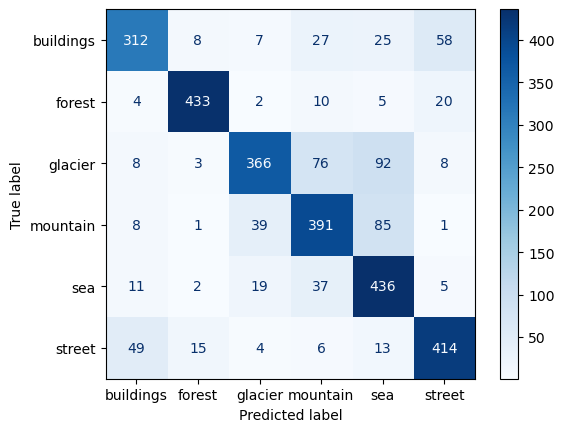

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       437
           1       0.94      0.91      0.93       474
           2       0.84      0.66      0.74       553
           3       0.71      0.74      0.73       525
           4       0.66      0.85      0.75       510
           5       0.82      0.83      0.82       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.78      0.78      3000



In [24]:
y_pred_all = convnn_all.predict(torch.tensor(X_test, dtype=torch.float32).permute(0,3,1,2), 50)
plot_confusion_matrix(test_labels, y_pred_all, True)

The addition of batch normalization and early stopping to the other features previously added to the CNN seems to have a small effect on the reclassification accuracy and the classification accuracy of the model. It may be helpful to compare the performance of the model across many runs of training and testing to see a more robust measure of average performance, however.

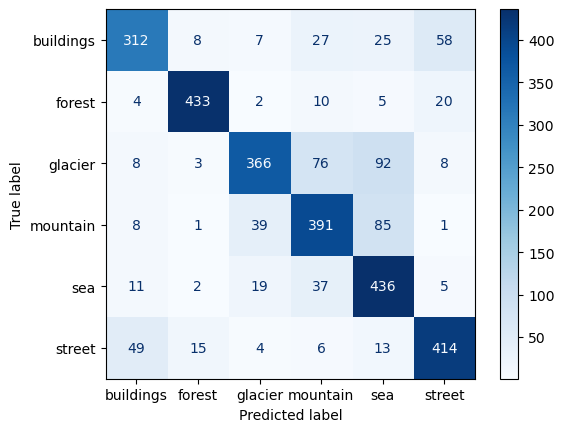

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       437
           1       0.94      0.91      0.93       474
           2       0.84      0.66      0.74       553
           3       0.71      0.74      0.73       525
           4       0.66      0.85      0.75       510
           5       0.82      0.83      0.82       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.78      0.78      3000



In [25]:
y_pred_all = convnn_all.predict(test_images_tensor_permuted, 50)
plot_confusion_matrix(test_labels, y_pred_all, True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..92.0].


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..124.0].


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..140.0].


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..210.0].


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..139.0].


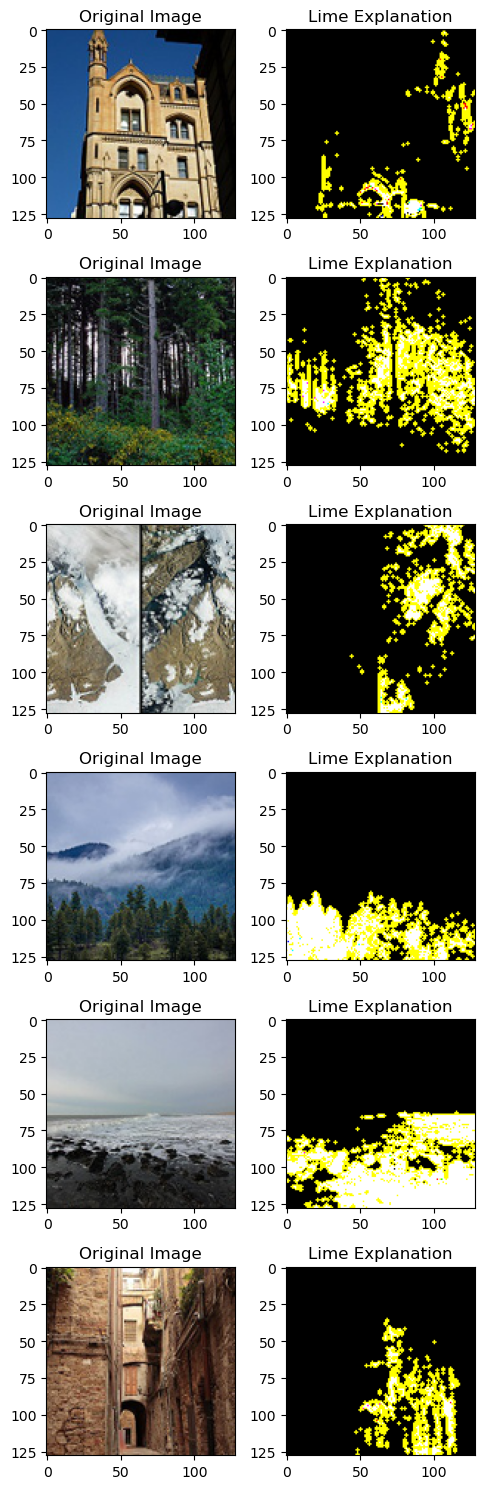

In [28]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

IMAGE_INDEX = 30

fig, ax = plt.subplots(len(image_classes), 2, figsize=(5,15))
explainer = lime_image.LimeImageExplainer(random_state=42)

def classifier_fn(images):
    images = np.array(images).astype('float32') / 255.0
    image_tensor = torch.tensor(images).permute(0,3,1,2)
    with torch.no_grad():
        probs = convnn_all.predict_proba(image_tensor, batch_size=1)
    return probs

for i, image_class in enumerate(image_classes):
    class_dir = os.path.join(train_dir, image_class)
    image = os.listdir(class_dir)[IMAGE_INDEX]
    image_path = os.path.join(class_dir, image)

    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMAGE_SIZE)
    img_np = np.array(img).astype('float32')

    explanation = explainer.explain_instance(
        img_np,
        classifier_fn,
        top_labels=2
    )

    top_label = explanation.top_labels[0]
    
    image, mask = explanation.get_image_and_mask(top_label, positive_only=True, hide_rest=True)

    ax[i, 0].imshow(img)
    ax[i, 0].set_title(f"Original Image")
    ax[i, 1].imshow(mark_boundaries(image, mask))
    ax[i, 1].set_title(f"Lime Explanation")

plt.tight_layout()

plt.show()